# 学習アルゴリズムを実装する

* ## 手順
1. #### ミニバッチ <br> 訓練データの中からランダムに一部のデータを選び出す。その選ばれたデータをミニバッチといい、ここではそのミニバッチの損失関数の値を減らすことを目標とする。
2. #### 勾配の算出<br>ミニバッチの損失関数を減らすために、各重みパラメータの勾配を求める。勾配は損失関数の値を最も減らす方向を示す。
3. #### パラメータの更新 <br> 重みパラメータを勾配方向に微小量だけ更新する。
4. #### ステップ1、ステップ2、ステップ3を繰り返す。

* ## 二層ニューラルネットワークの実装

In [18]:
import numpy as np

# 勾配を求める関数の実装
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x + h)の計算
        x[idx] = tmp_val + h
        fxh1 = f(x)

        #f(x - h)の計算
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val #値を元に戻す

    return grad

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(a):
    c = np.max(a) # オーバーフロー対策
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a

    return y

# y : 出力、t : 教師データ
def cross_entropy_error(y, t):
    delta = 1e-7 # 無限大対策
    return -np.sum(t * np.log(y + delta))

In [120]:
import sys, os
sys.path.append(os.pardir)
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet:

    # input_size : 入力層のニューロンの数, hidden_size : 隠れ層のニューロンの数, output_size : 出力層のニューロンの数
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        # 一層目
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        # 二層目
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        # 第一層
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        # 第二層
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y

    # 損失関数。 x : 入力データ、t : 教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)

    # 正解率を出す
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 入力データ、 t : 教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W : self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

In [20]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
# 重み行列、バイアス行列の形確認
# (行, 列）の順。数値が入っていない場合は1行,列ということ
print('W1 : ' + str(net.params['W1'].shape))
print('b1 : ' + str(net.params['b1'].shape))
print('W2 : ' + str(net.params['W2'].shape))
print('b2 : ' + str(net.params['b2'].shape))

W1 : (784, 100)
b1 : (100,)
W2 : (100, 10)
b2 : (10,)


* ## ミニバッチ学習の実装

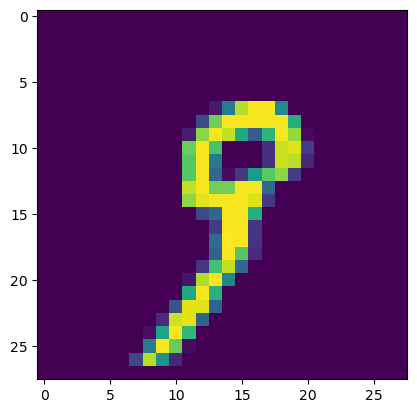

In [78]:
import numpy as np
from dataset.mnist import load_mnist

# 書籍のコードが一番便利（正規化もしてくれるしOnehot表現にも直してくれる）
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# 試しに中身を取り出してみる
plt.imshow(x_train[19].reshape(28,28))
plt.show()

### ミニバッチのサイズを100として、毎回60000万個の訓練データからランダムに100個抜き出して、勾配を求め、確率勾配降下法（SGD）でパラメータを更新する。<br>ここでは勾配法による繰り返し回数を10000回とする。

In [70]:

train_loss_list = []

# ハイパーパラメータ
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1


network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 勾配の計算
    grad = network.gradient(x_batch, t_batch)
    # grad = network.gradient(x_batch, t_batch) # 高速版

    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]


    # 学習経過の記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

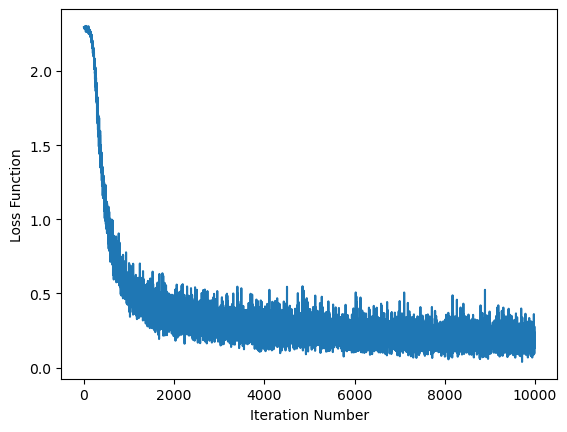

In [94]:
# 損失関数の推移をプロットしてみる
plt.xlabel('Iteration Number')
plt.ylabel('Loss Function')
plt.plot(train_loss_list)
plt.show()

### 確かに勾配を再計算して加えることで損失関数が減少＝学習が進んでいる！

* # テストデータで評価する

* ### 1 エポック（epoch）とは？
### わかりにくいので具体例を出すと、例えば10000個のデータセットに対して100個のミニバッチを抜き出してSGDを行う場合、100回繰り返せば全ての訓練データを「みた」ことになる。（とするらしい。）この場合、1エポック = 100回

In [104]:
import numpy as np

# ハイパーパラメータ
iters_num = 10000
batch_size = 100
learning_rate = 0.1
train_size = x_train.shape[0]

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1エポックあたりの繰り返し回数
iters_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 勾配の計算
    grad = network.gradient(x_batch, t_batch)
    # grad = network.gradient(x_batch, t_batch) # 高速版

    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]


    # 学習経過の記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    # ここから先が追加された
    if i % iters_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('train accuracy, test accuracy | ' + str(train_acc) + ', ' + str(test_acc))

train accuracy, test accuracy | 0.09863333333333334, 0.0958
train accuracy, test accuracy | 0.7820833333333334, 0.7835
train accuracy, test accuracy | 0.8751, 0.8791
train accuracy, test accuracy | 0.89665, 0.8984
train accuracy, test accuracy | 0.9072166666666667, 0.9088
train accuracy, test accuracy | 0.9134666666666666, 0.9152
train accuracy, test accuracy | 0.9183666666666667, 0.9197
train accuracy, test accuracy | 0.9231166666666667, 0.9236
train accuracy, test accuracy | 0.9264333333333333, 0.9292
train accuracy, test accuracy | 0.9302, 0.9324
train accuracy, test accuracy | 0.9332166666666667, 0.9344
train accuracy, test accuracy | 0.9364, 0.937
train accuracy, test accuracy | 0.9382666666666667, 0.9387
train accuracy, test accuracy | 0.9406833333333333, 0.9408
train accuracy, test accuracy | 0.9429333333333333, 0.9422
train accuracy, test accuracy | 0.9442666666666667, 0.9426
train accuracy, test accuracy | 0.9456666666666667, 0.9441


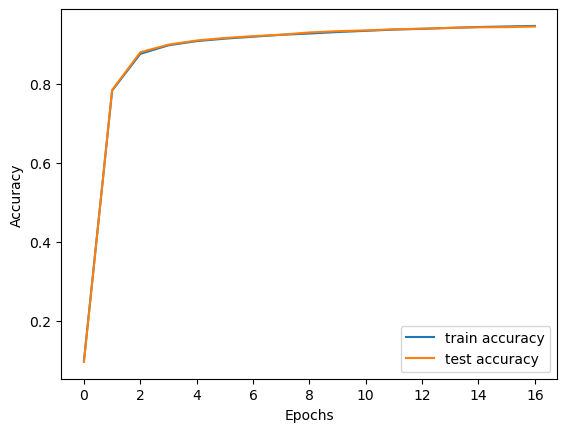

In [114]:
plt.plot(train_acc_list, label='train accuracy')
plt.plot(test_acc_list, label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 認識精度の線はほぼ重なっているため、過学習が起きていないことが確認できた。

#### （ただ世の中の大抵のデータでははテストデータの正解はわからないのでこの検証方法はあまり良くない。。。Cross Validationとか使うと良い。）

# 書籍中のコードを使わずにMNISTデータセットを読み出してみた

画像の縦横サイズ : (28, 28)


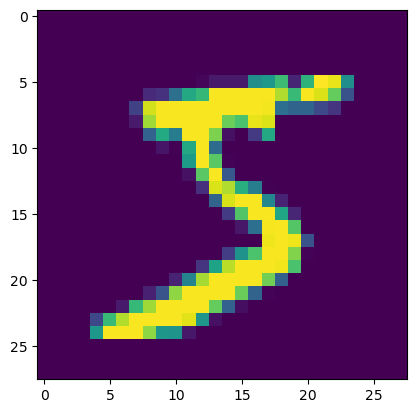

画像の正解ラベル : 5


In [60]:
import pickle

data_file_path = './dataset-by-myself/mnist.pkl'
# データを読み込む
# 各データはリストになっており、train_img,train_label,test_img,test_labelという名前がついている

with open(data_file_path, 'rb') as f:
    dataset = pickle.load(f)

# 画像データの中身の確認
import matplotlib.pyplot as plt

example = dataset['train_img'][0].reshape((28, 28))
ex_label = dataset['train_label'][0]

print('画像の縦横サイズ : ' + str(example.shape))
plt.imshow(example)
plt.show()

print('画像の正解ラベル : ' + str(ex_label))

In [23]:
# そのままでは行列の形が合わないのでラベルをOne-Hot表現に変更
def to_one_hot(label):
    T = np.zeros((label.size, 10))
    for i in range(label.size):
        T[i][label[i]] = 1
    return T

dataset['train_label'] = to_one_hot(dataset['train_label'])
dataset['test_label'] = to_one_hot(dataset['test_label'])
dataset['train_label'].shape    #-> (60000, 10)

(60000, 10)